In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

In [5]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_data(base_path, folds=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):
    audio_data = []
    labels = []
    filenames = [] 
    for fold in folds:
        fold_path = os.path.join(base_path, f"fold{fold}")
        for file in os.listdir(fold_path):
            if file.endswith(".wav"):
                file_path = os.path.join(fold_path, file)
                audio, sr = librosa.load(file_path, sr=None)
                audio_data.append(audio)
                labels.append(int(file.split("-")[1]))  # Extract label from filename
                filenames.append(file) 
    return audio_data, labels, filenames


def apply_window(audio, window_type="hann"):
    if window_type == "hann":
        window = np.hanning(len(audio))
    elif window_type == "hamming":
        window = np.hamming(len(audio))
    elif window_type == "rectangular":
        window = np.ones(len(audio))
    else:
        raise ValueError("Invalid window type")
    return audio * window


def generate_spectrogram(audio, sr, window_type="hann"):
    windowed_audio = apply_window(audio, window_type)
    stft = librosa.stft(windowed_audio)
    spectrogram = np.abs(stft)
    return spectrogram


def plot_spectrogram(spectrogram, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                             sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()
    

def extract_features(spectrogram):
    # Extract mean and standard deviation as features
    return np.concatenate((np.mean(spectrogram, axis=1), np.std(spectrogram, axis=1)))


def limit_samples(samples, labels, max_samples=10):
    return samples[:max_samples], labels[:max_samples]


def train_and_evaluate_svm(X_train, y_train, X_test, y_test, window_type):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Measure training time
    start_time = time.time()
    model = SVC(kernel="linear")
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Evaluate training performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Evaluate test performance
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Classification report
    print(f"Classification Report for {window_type} window:")
    print(classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(10)]))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {window_type} Window")
    plt.show()
    
    print(f"Results for {window_type} window:")
    print(f"  Training Accuracy: {train_accuracy:.2f}")
    print(f"  Test Accuracy: {test_accuracy:.2f}")
    print(f"  Training Time: {training_time:.2f} seconds")
    print()
    
    return train_accuracy, test_accuracy, training_time



Classification Report for hann window:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       184
           1       0.78      0.62      0.69        76
           2       0.50      0.77      0.61       210
           3       0.64      0.54      0.59       199
           4       0.81      0.70      0.75       207
           5       0.81      0.81      0.81       192
           6       0.57      0.53      0.55        73
           7       0.87      0.84      0.86       222
           8       0.78      0.80      0.79       179
           9       0.73      0.51      0.60       205

    accuracy                           0.71      1747
   macro avg       0.72      0.69      0.70      1747
weighted avg       0.72      0.71      0.71      1747



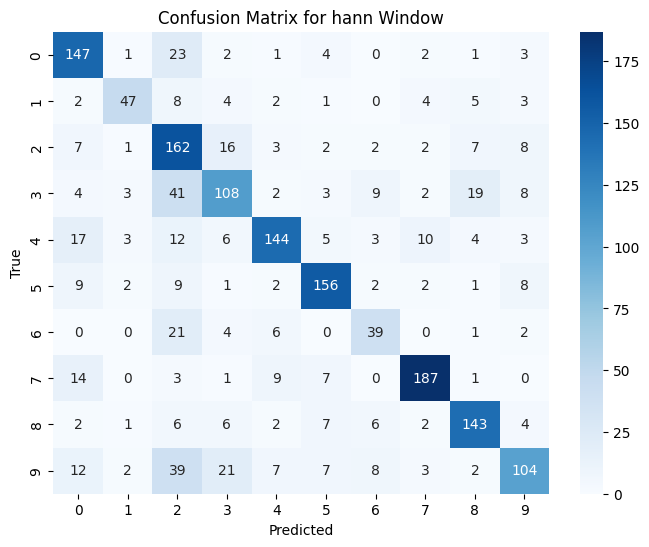

Results for hann window:
  Training Accuracy: 0.91
  Test Accuracy: 0.71
  Training Time: 47.90 seconds

Classification Report for hamming window:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       184
           1       0.81      0.63      0.71        76
           2       0.53      0.77      0.63       210
           3       0.65      0.55      0.60       199
           4       0.79      0.67      0.72       207
           5       0.82      0.83      0.83       192
           6       0.66      0.66      0.66        73
           7       0.88      0.85      0.86       222
           8       0.76      0.82      0.79       179
           9       0.73      0.51      0.60       205

    accuracy                           0.72      1747
   macro avg       0.73      0.71      0.71      1747
weighted avg       0.73      0.72      0.72      1747



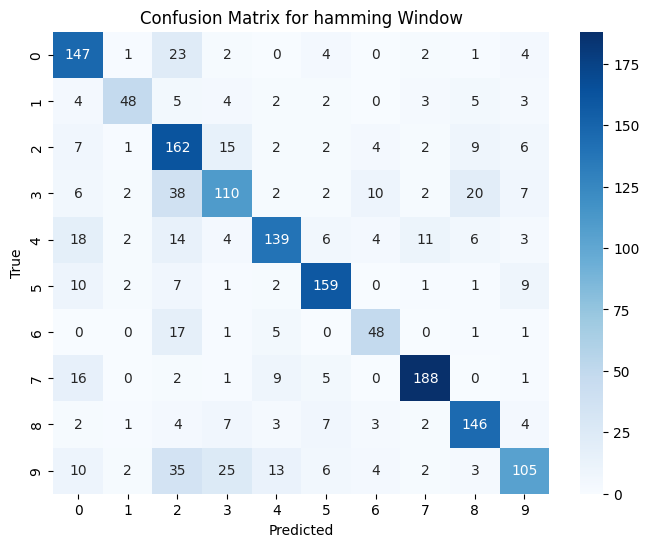

Results for hamming window:
  Training Accuracy: 0.91
  Test Accuracy: 0.72
  Training Time: 46.40 seconds

Classification Report for rectangular window:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       184
           1       0.81      0.68      0.74        76
           2       0.56      0.78      0.65       210
           3       0.64      0.54      0.59       199
           4       0.80      0.66      0.72       207
           5       0.87      0.89      0.88       192
           6       0.84      0.85      0.84        73
           7       0.87      0.89      0.88       222
           8       0.79      0.82      0.80       179
           9       0.76      0.54      0.63       205

    accuracy                           0.75      1747
   macro avg       0.77      0.76      0.76      1747
weighted avg       0.76      0.75      0.75      1747



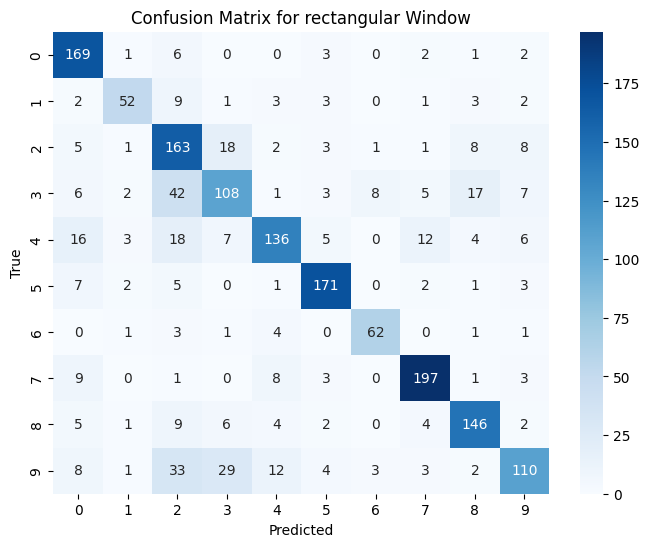

Results for rectangular window:
  Training Accuracy: 0.93
  Test Accuracy: 0.75
  Training Time: 41.32 seconds



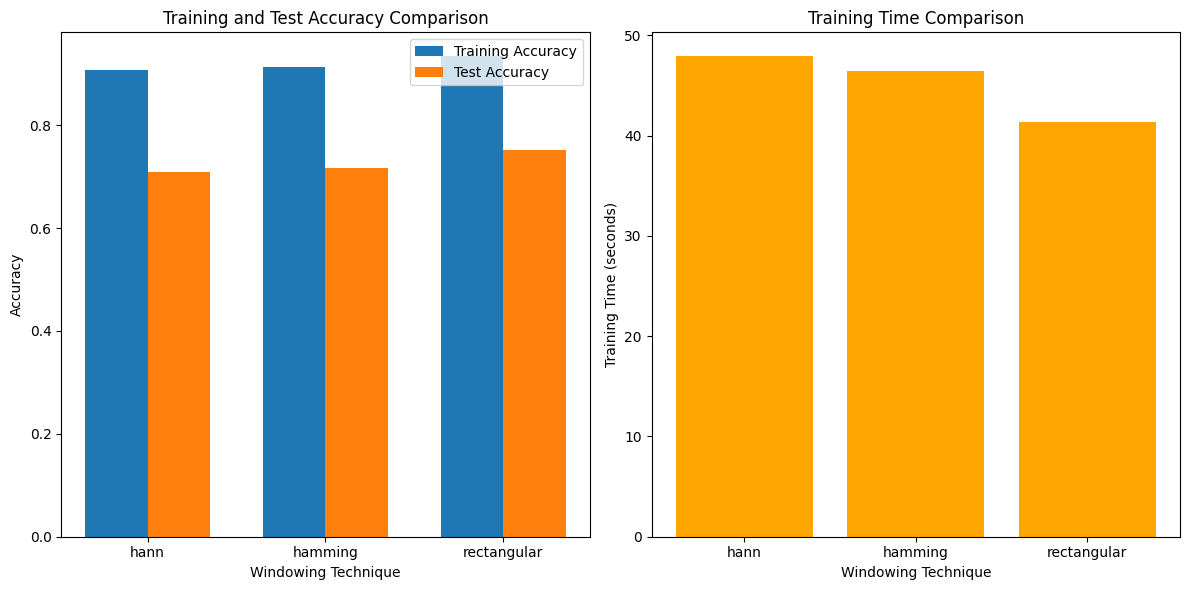

In [6]:

if __name__ == "__main__":
    base_path = "/kaggle/input/urbansound8k"  # Update this path
    audio_data, labels, filenames = load_data(base_path, folds=[1,2,3,4,5,6,7,8,9,10]) 

    # Generate spectrograms for each windowing technique
    window_types = ["hann", "hamming", "rectangular"]
    window_colors = {
        "hann": "viridis",  
        "hamming": "plasma",  
        "rectangular": "inferno"  
    }
    
    results = {
        "window_type": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "training_time": []
    }
    
    for window_type in window_types:
        spectrograms = []
        for audio in audio_data:
            spectrogram = generate_spectrogram(audio, sr=22050, window_type=window_type)
            spectrograms.append(extract_features(spectrogram))
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)
        
        # Train and evaluate SVM
        train_acc, test_acc, train_time = train_and_evaluate_svm(X_train, y_train, X_test, y_test, window_type)
        
        # Store results
        results["window_type"].append(window_type)
        results["train_accuracy"].append(train_acc)
        results["test_accuracy"].append(test_acc)
        results["training_time"].append(train_time)
    
    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot training and test accuracy
    plt.subplot(1, 2, 1)
    x = np.arange(len(window_types))
    width = 0.35
    plt.bar(x - width/2, results["train_accuracy"], width, label="Training Accuracy")
    plt.bar(x + width/2, results["test_accuracy"], width, label="Test Accuracy")
    plt.xlabel("Windowing Technique")
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy Comparison")
    plt.xticks(x, window_types)
    plt.legend()

    # Plot training time
    plt.subplot(1, 2, 2)
    plt.bar(window_types, results["training_time"], color="orange")
    plt.xlabel("Windowing Technique")
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time Comparison")

    plt.tight_layout()
    plt.show()

In [1]:

def load_samples(base_path, num_samples=1):
    samples = []
    labels = []
    filenames = []  # Store filenames
    fold_names = []  # Store fold names

    for fold in range(1, 11):  # Folders 1 to 10
        fold_path = os.path.join(base_path, f"fold{fold}")
        files = [f for f in os.listdir(fold_path) if f.endswith(".wav")]
        
        for file in files[:num_samples]:  # Load first 2 samples from each folder
            file_path = os.path.join(fold_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            samples.append(audio)
            labels.append(int(file.split("-")[1]))  # Extract label from filename
            filenames.append(file)  # Store filename
            fold_names.append(f"fold{fold}")  # Store fold name
    
    return samples, labels, filenames, fold_names


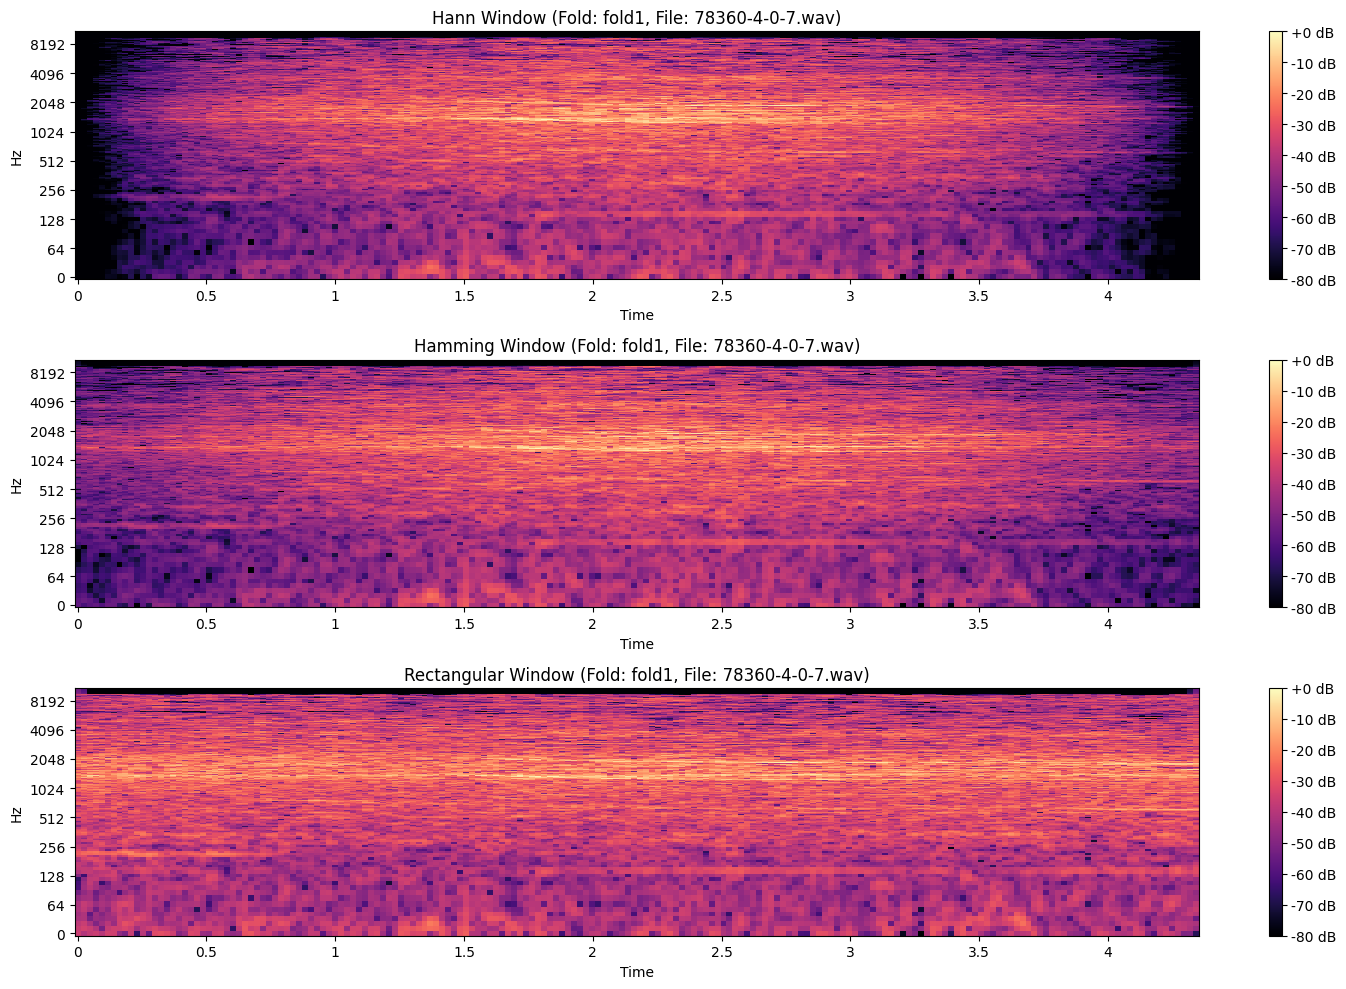

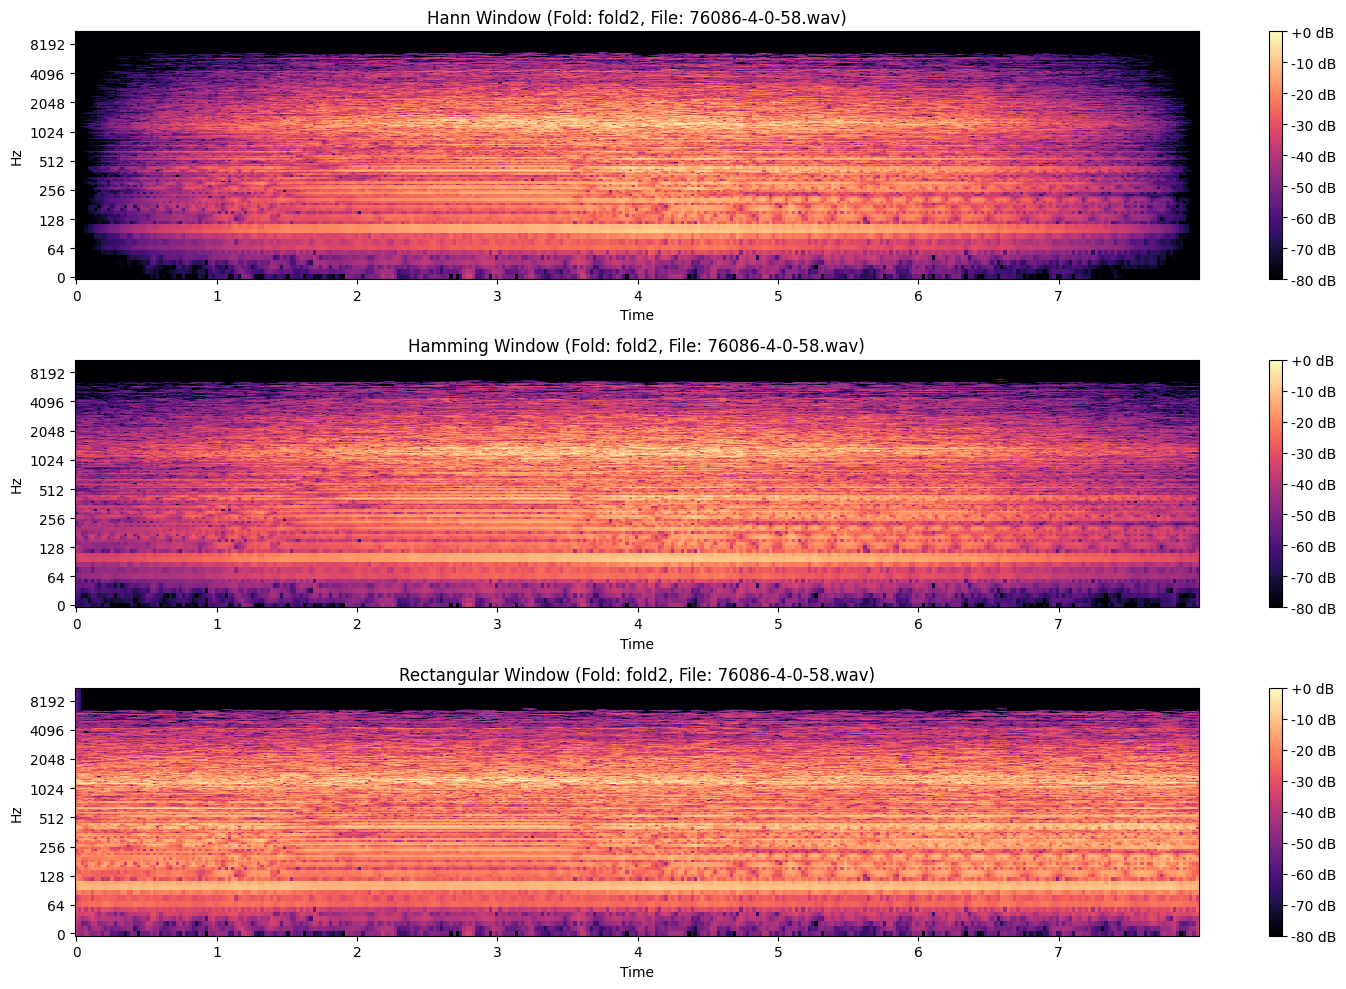

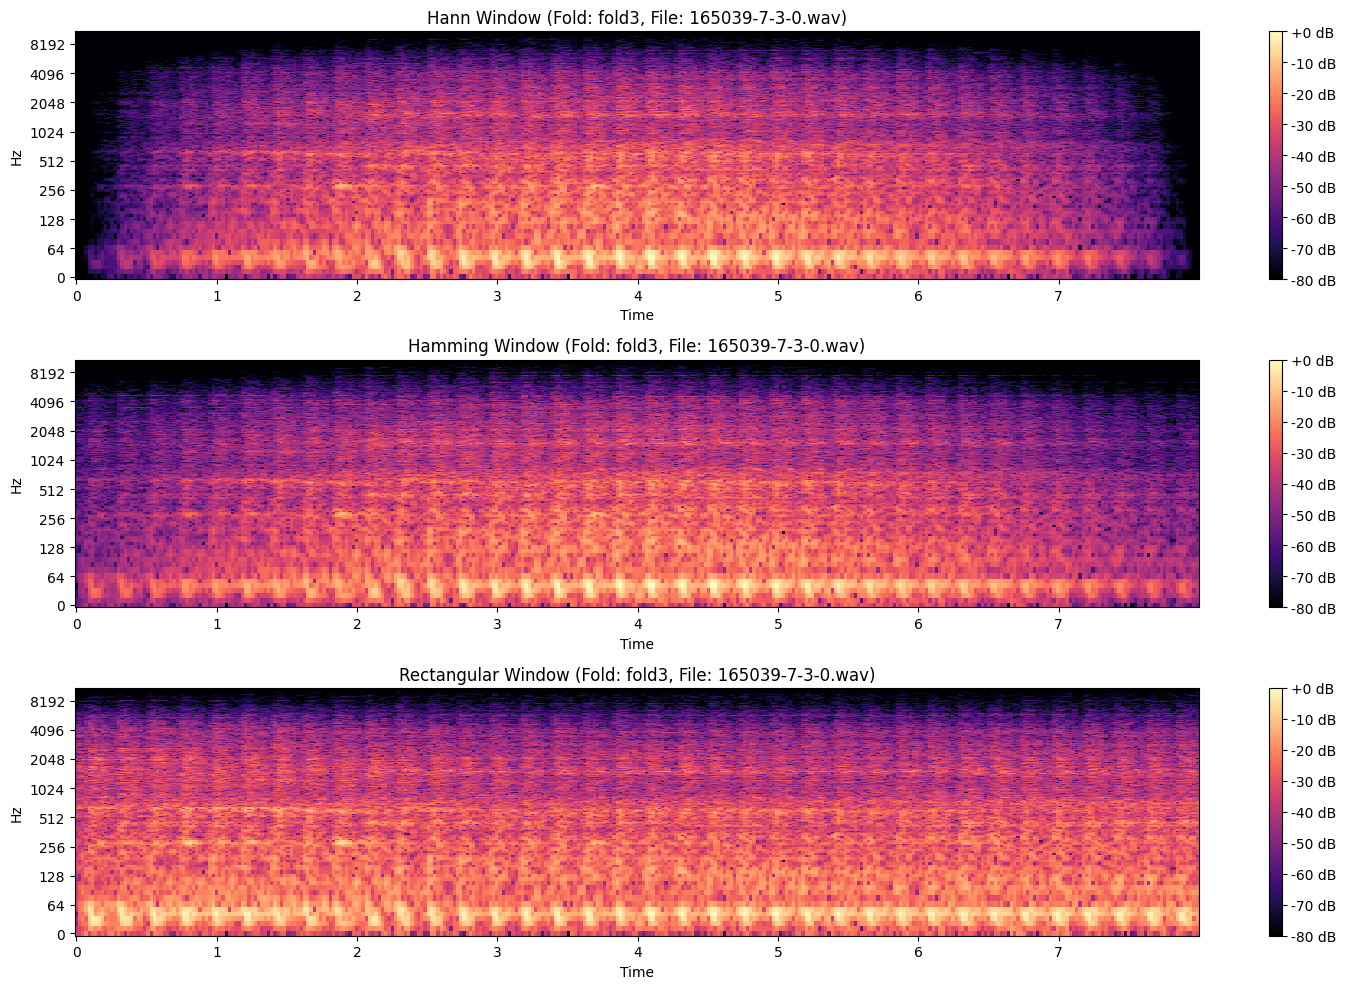

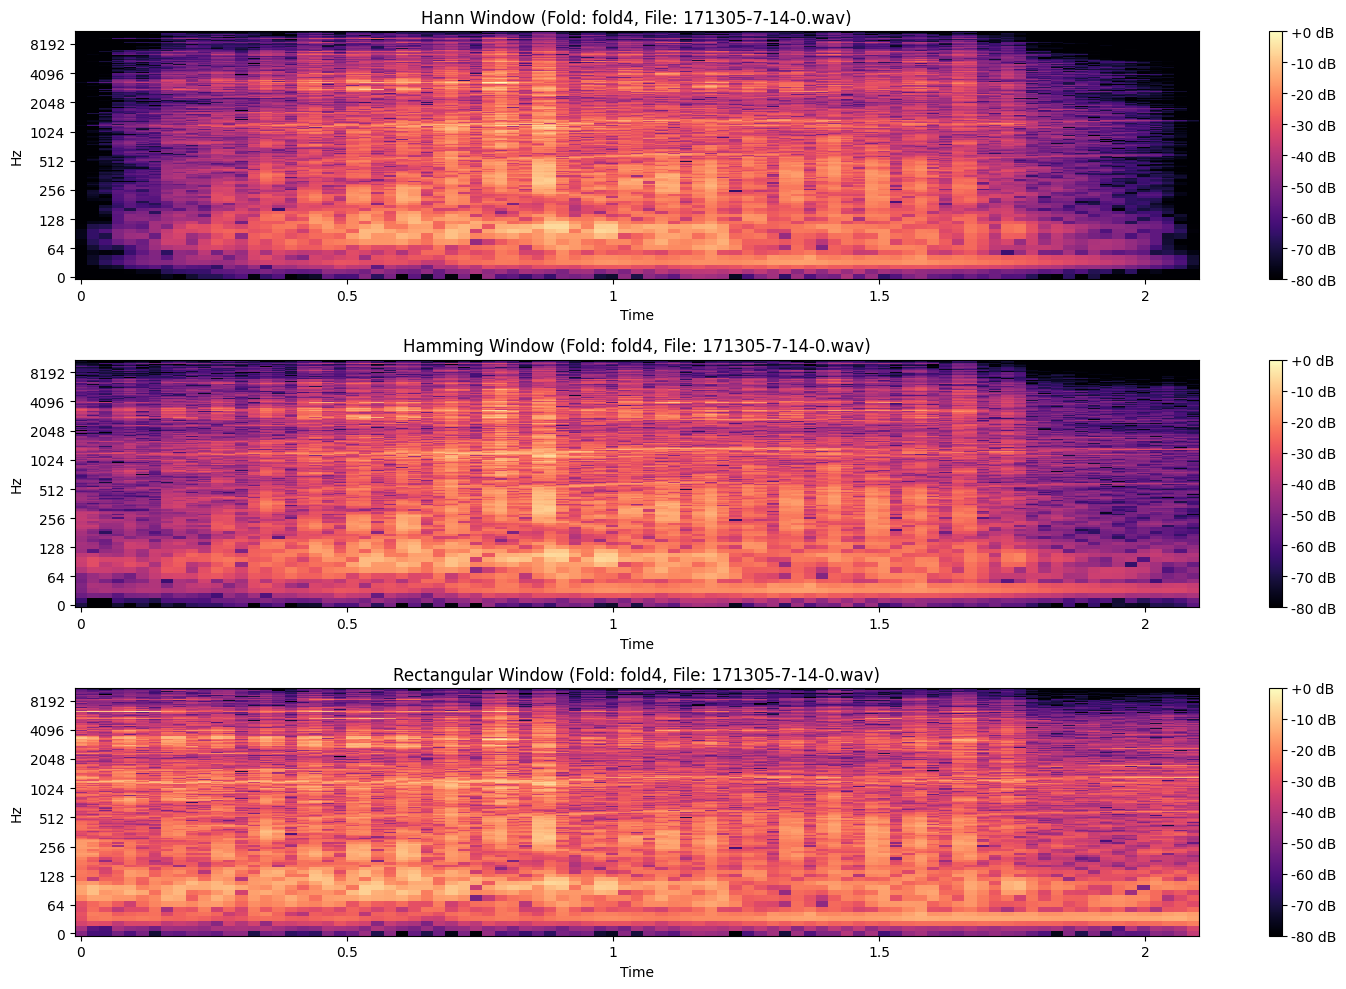

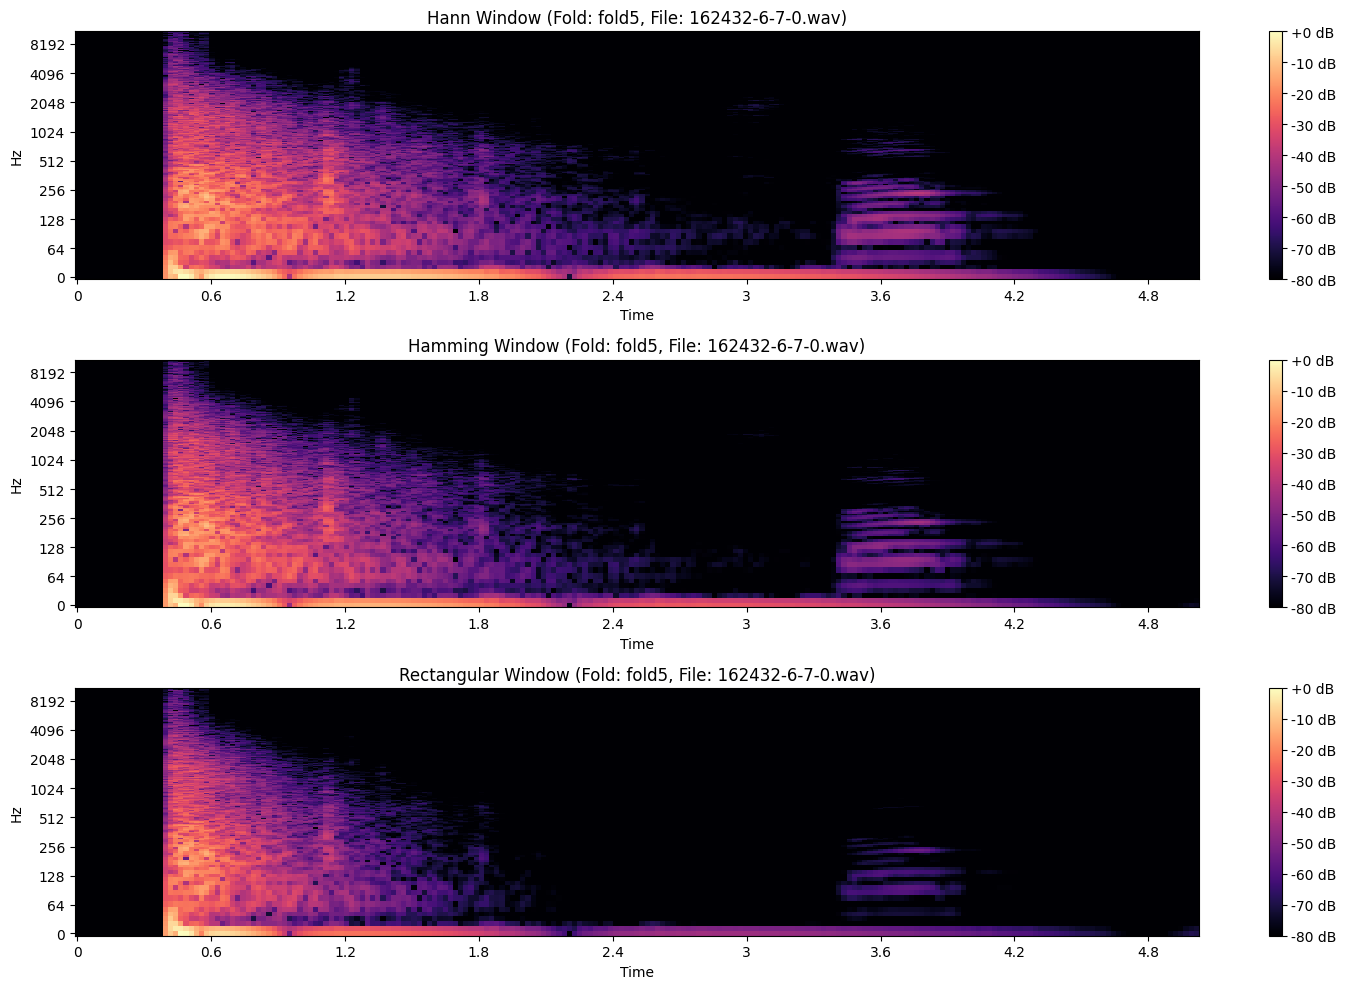

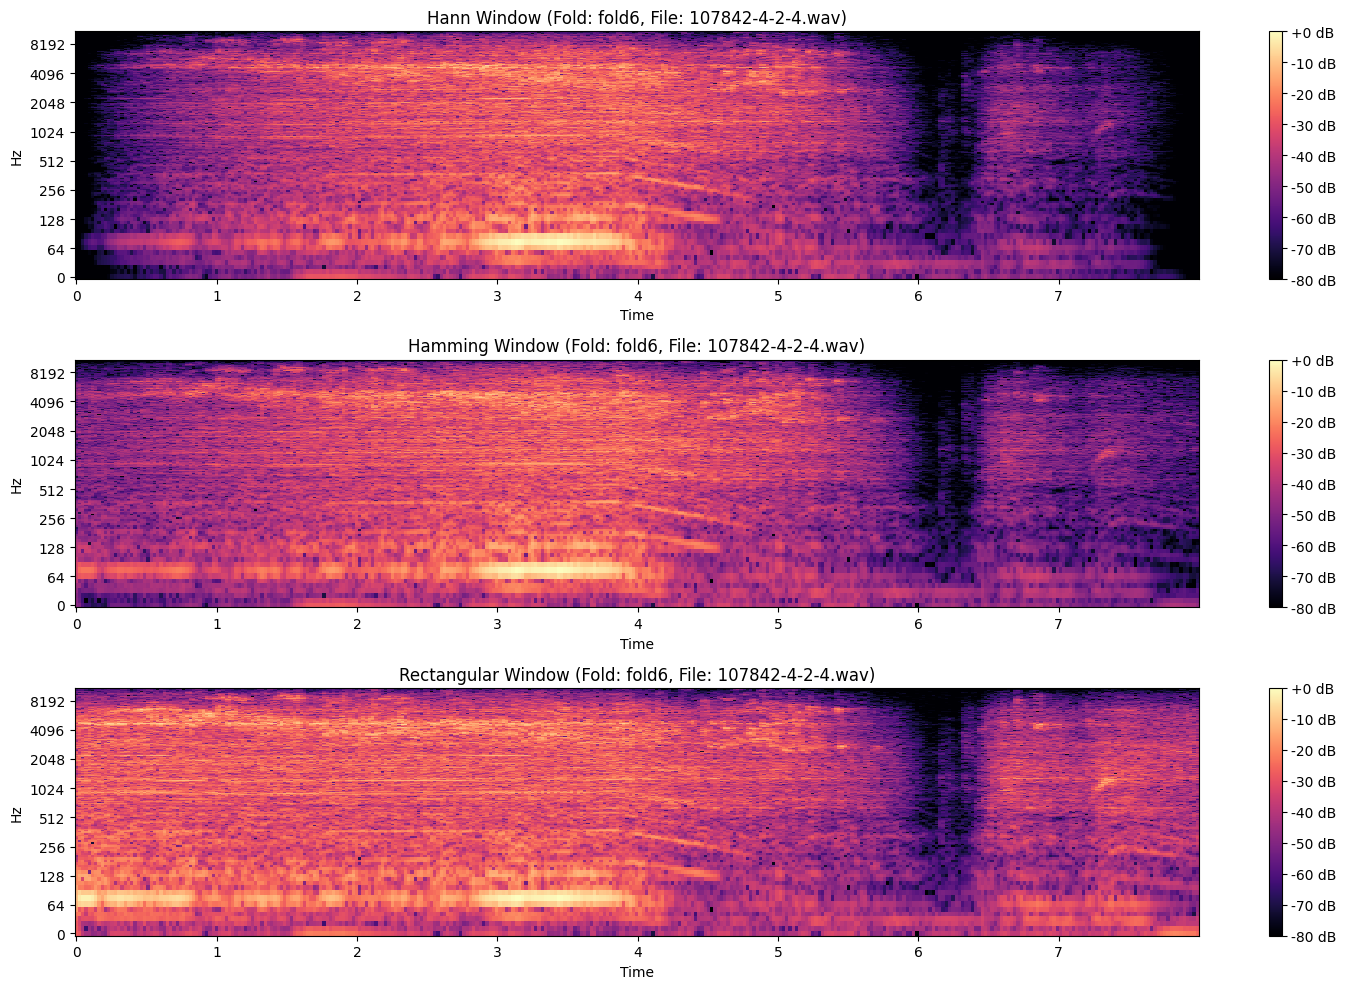

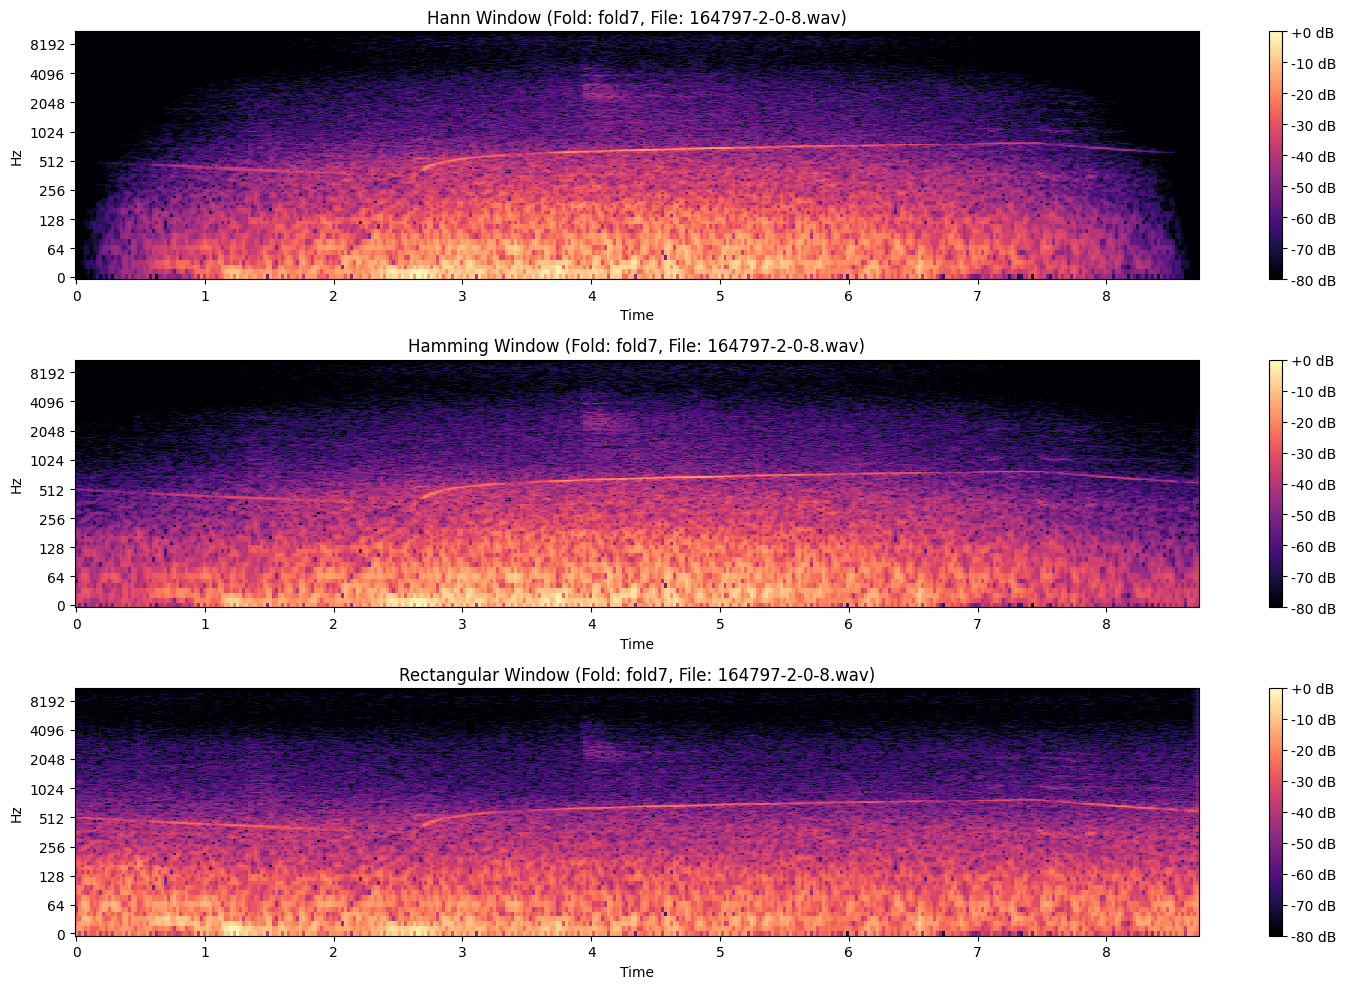

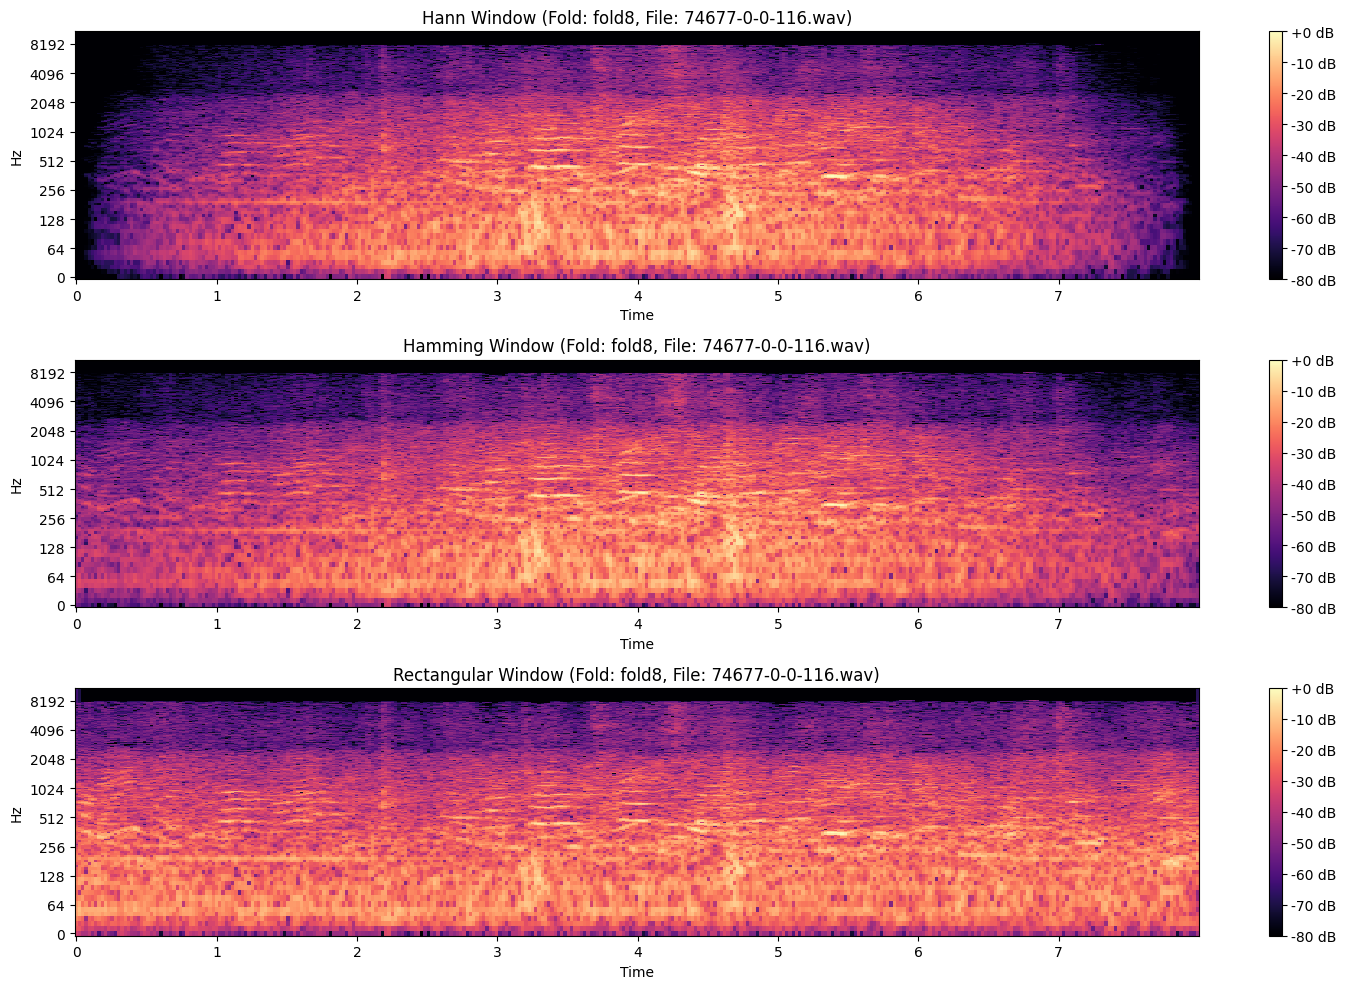

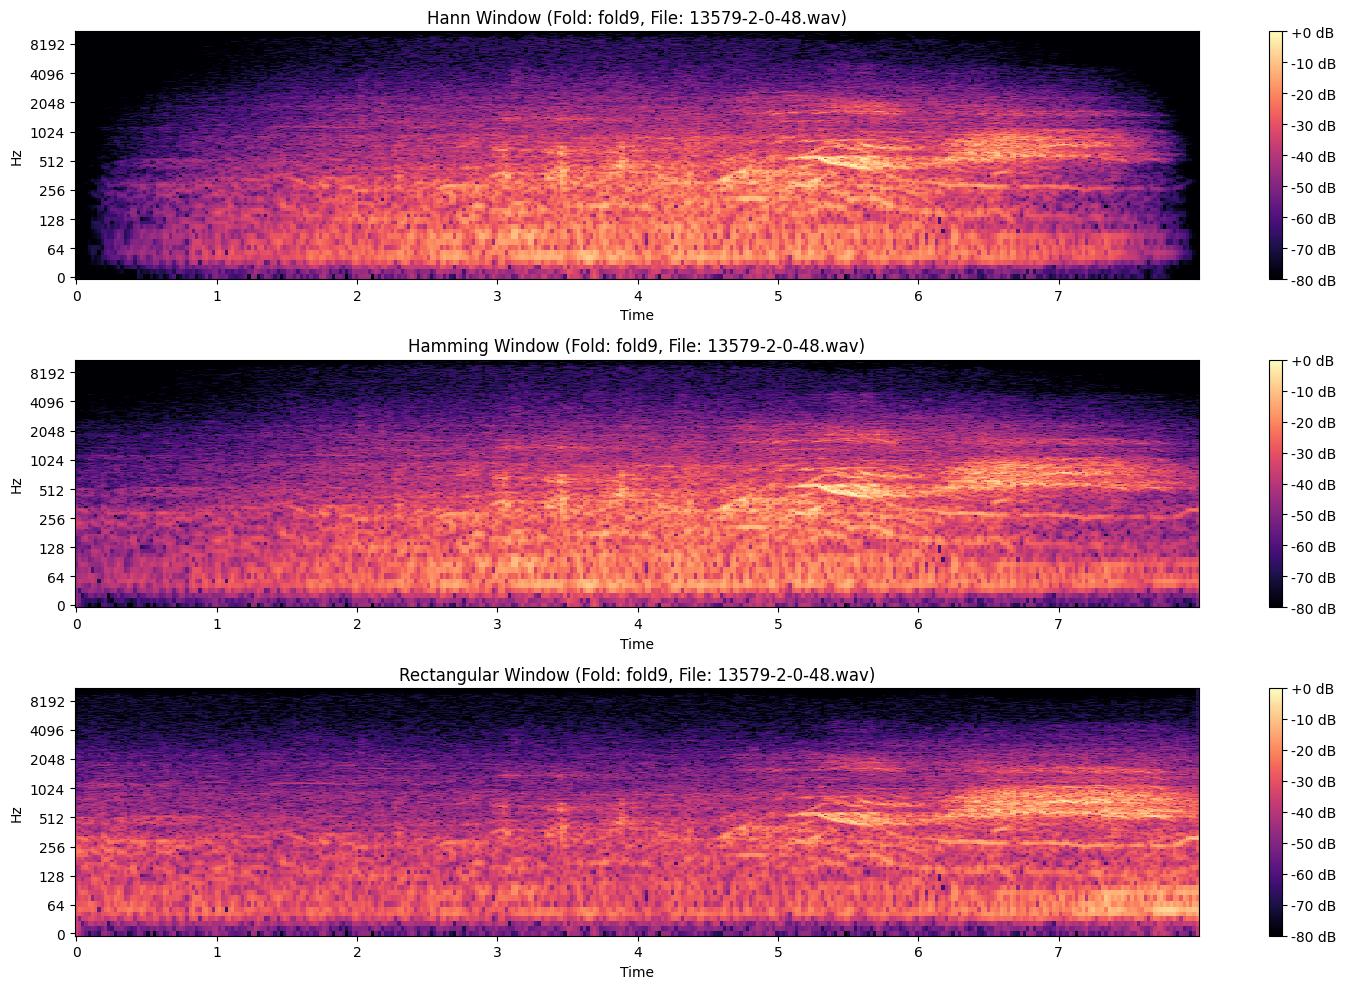

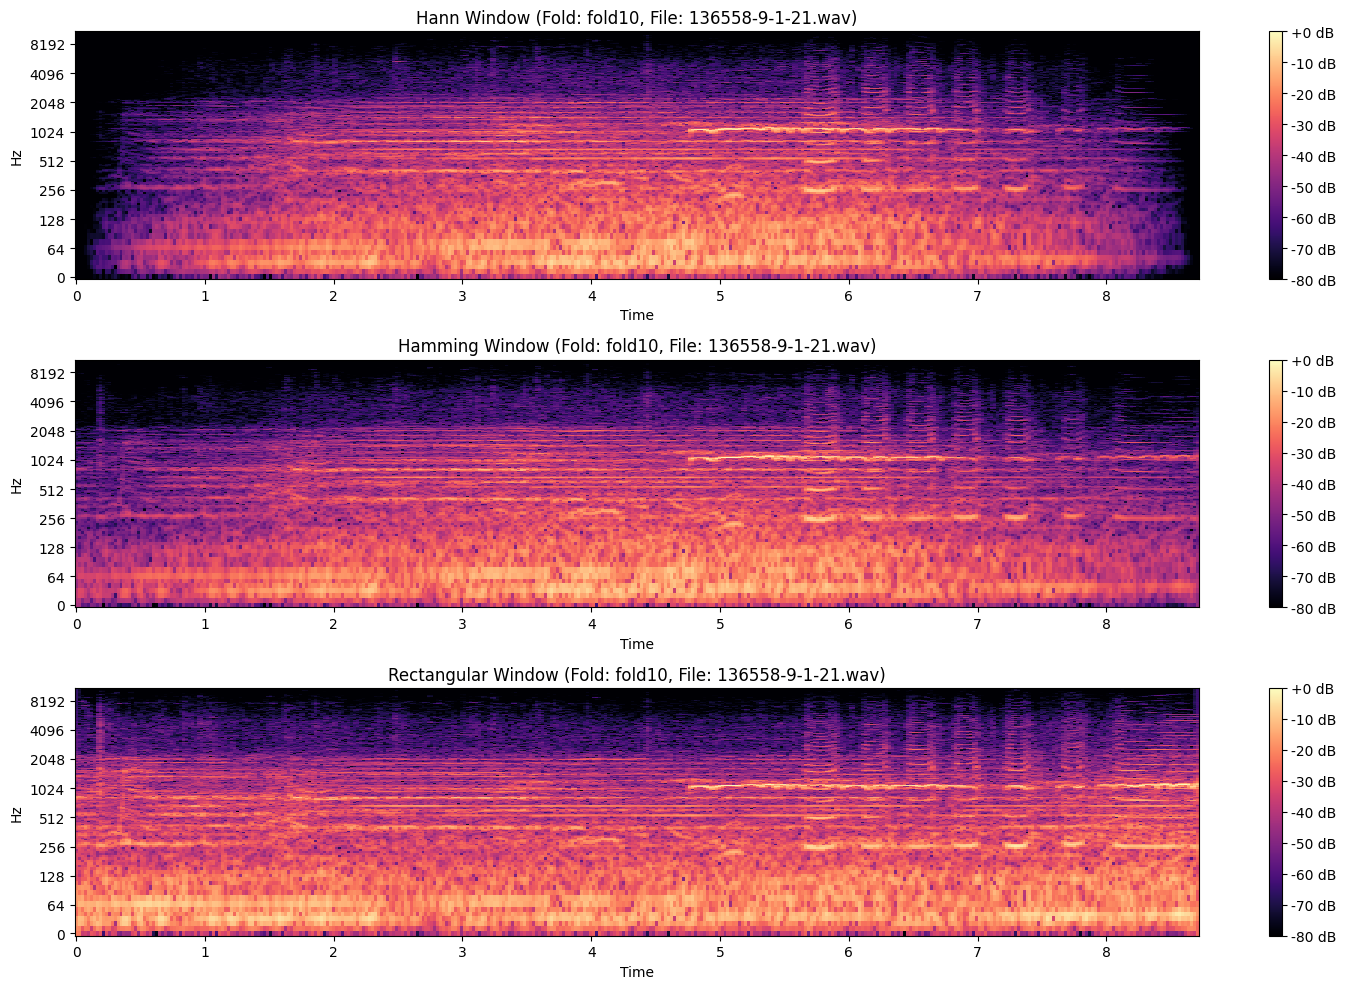

In [10]:
# Load the samples
audio_data_plot, labels_plot, filenames_plot, fold_names_plot = load_samples(base_path, num_samples=1)

# Plot spectrograms for each windowing technique in a single graph
for i, audio in enumerate(audio_data_plot):
    # Get the fold name directly from the returned fold_names
    fold_name = fold_names_plot[i]
    
    # Create a single figure for each audio file
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization
    
    for j, window_type in enumerate(window_types):
        # Generate the spectrogram
        spectrogram = generate_spectrogram(audio, sr=22050, window_type=window_type)
        
        # Plot the spectrogram in a subplot
        plt.subplot(3, 1, j + 1)  # 1 row, 3 columns (for Hann, Hamming, Rectangular)
        librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                 sr=22050, x_axis="time", y_axis="log")
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"{window_type.capitalize()} Window (Fold: {fold_name}, File: {filenames_plot[i]})")
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

Line Chart

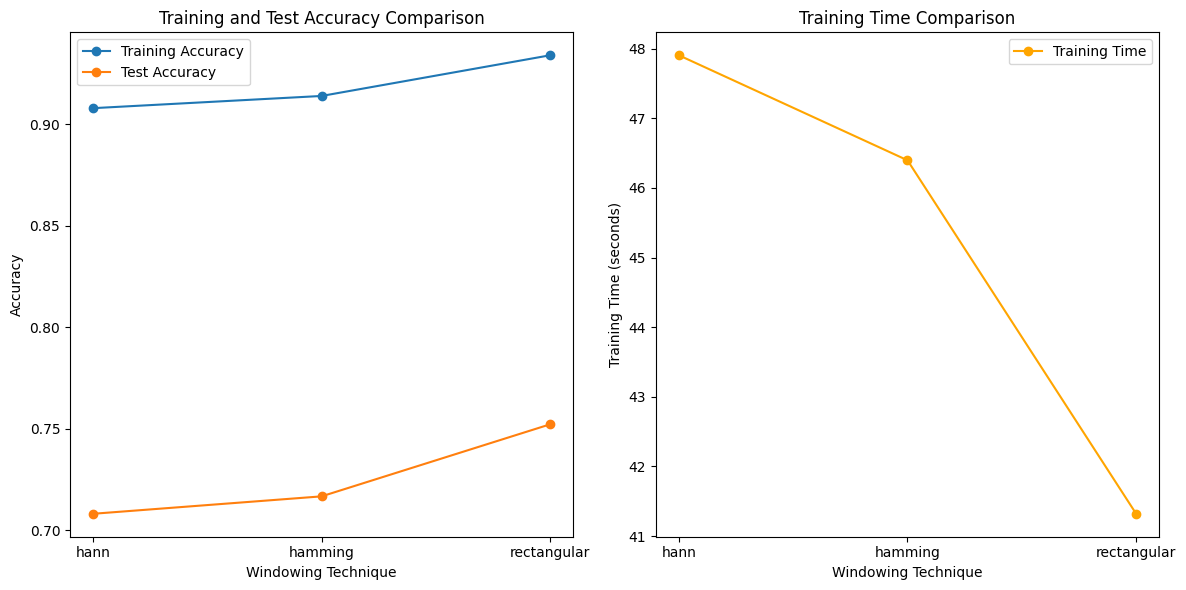

In [2]:
plt.figure(figsize=(12, 6))

# Plot training and test accuracy
plt.subplot(1, 2, 1)
plt.plot(results["window_type"], results["train_accuracy"], marker="o", label="Training Accuracy")
plt.plot(results["window_type"], results["test_accuracy"], marker="o", label="Test Accuracy")
plt.xlabel("Windowing Technique")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Comparison")
plt.legend()

# Plot training time
plt.subplot(1, 2, 2)
plt.plot(results["window_type"], results["training_time"], marker="o", color="orange", label="Training Time")
plt.xlabel("Windowing Technique")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.legend()

plt.tight_layout()
plt.show()

Heatmap

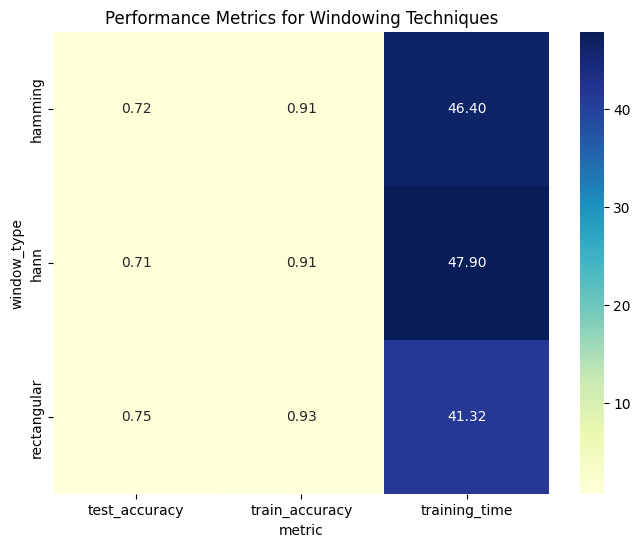

In [4]:
import pandas as pd
import seaborn as sns

# Create a DataFrame for the results
df = pd.DataFrame(results)

# Pivot the DataFrame for the heatmap
df_melted = df.melt(id_vars=["window_type"], var_name="metric", value_name="value")

# Plot heatmap
plt.figure(figsize=(8, 6))
heatmap_data = df_melted.pivot(index="window_type", columns="metric", values="value")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Performance Metrics for Windowing Techniques")
plt.show()

Radar Chart

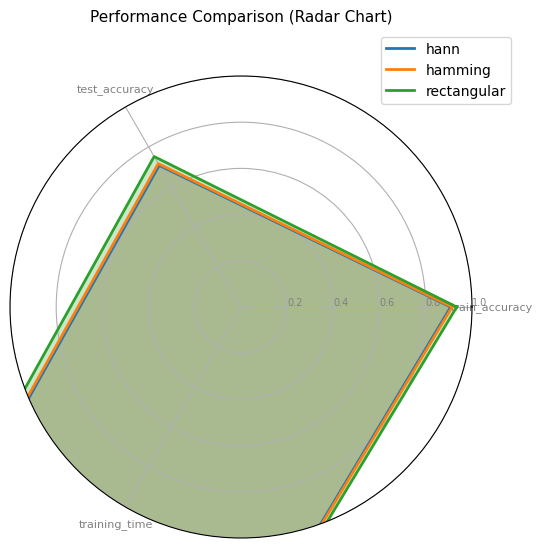

In [5]:
from math import pi

# Prepare data for radar chart
categories = list(results.keys())[1:]  # Exclude 'window_type'
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the circle

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories, color="grey", size=8)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each windowing technique
for i, window in enumerate(results["window_type"]):
    values = [results[metric][i] for metric in categories]
    values += values[:1]  # Close the circle
    ax.plot(angles, values, linewidth=2, linestyle="solid", label=window)
    ax.fill(angles, values, alpha=0.25)

plt.title("Performance Comparison (Radar Chart)", size=11, y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.show()

Stacked Bar Chart

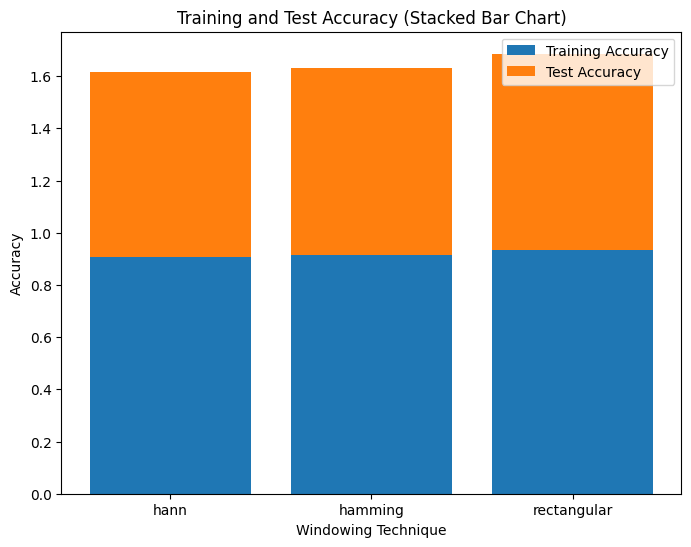

In [6]:
plt.figure(figsize=(8, 6))

# Plot stacked bar chart
plt.bar(results["window_type"], results["train_accuracy"], label="Training Accuracy")
plt.bar(results["window_type"], results["test_accuracy"], bottom=results["train_accuracy"], label="Test Accuracy")
plt.xlabel("Windowing Technique")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy (Stacked Bar Chart)")
plt.legend()

plt.show()